# Project Name: See America

## Goal

To determine the fewest number of sites to visit to see the most of US land area.

## Objectives

1. Install python and cartopy and display map of US (Complete: 6/12/21)
2. Get elevation of any point within US (Complete: 6/20/21)
3. Draw a circle of visibility 14-90 miles around any point on map [UC Davis](https://airquality.ucdavis.edu/visibility-regulations-trends) (7/4/21)
    1. Bonus points for making visibility a function of air quality
4. Draw a sphere with center of lon,lat,elev and radius of visibility
5. Pack US surface map with non-overlapping spheres (sphere centers on surface) following sphere fitting method of [Bouxsein, Guldberg, JBMR](https://asbmr.onlinelibrary.wiley.com/doi/pdf/10.1002/jbmr.141)
    1. Bonus points for subtracting sphere volume not in line of sight (e.g. behind a ridge or mountain)
6. For each resulting sphere, calculate area of intersection between earth surface and sphere (representing what is 'seen' of earth's surface)
7. Plot pareto of number of spheres (sites visited) vs intersection area to find 80/20 of visiting fewest number of sites to see most of the US

## Objective 1: Install python and cartopy and display map of US

### Helpful links

[Python Indroduction to Cartopy (Youtube)](https://www.youtube.com/watch?v=4M2aiHvhr5Y) and [Jupyter notebook link](https://github.com/groundhogday321/python-cartopy/blob/master/Python%20Cartopy.ipynb)

### Imports

In [6]:
#Objective 1
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

### Plot map of US

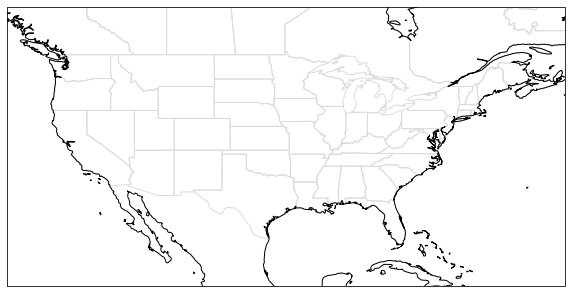

In [7]:
fig = plt.figure(figsize=(10,10))
map = plt.axes(projection=ccrs.PlateCarree())
map.set_extent([-130, -60, 20, 55], ccrs.PlateCarree())
map.add_feature(cfeature.STATES, edgecolor='gainsboro')
map.coastlines()

## Objective 2: Get elevation of any point in US

### Elevation data sources

- [JISAO](http://research.jisao.washington.edu/data_sets/elevation/)
- [UCSD TOPEX](https://topex.ucsd.edu/cgi-bin/get_data.cgi), ([non-cartopy tutorial](https://towardsdatascience.com/plotting-regional-topographic-maps-from-scratch-in-python-8452fd770d9d))
- [USGS Elevation Point Query Service](https://nationalmap.gov/epqs/) (1-2 seconds per query,[link1](https://gis.stackexchange.com/questions/338392/getting-elevation-for-multiple-lat-long-coordinates-in-python))
- [SRTM 90m](https://cgiarcsi.community/data/srtm-90m-digital-elevation-database-v4-1/)
- [open-elevation.com](https://open-elevation.com/)
- [google elevation API](https://developers.google.com/maps/documentation/elevation/overview)
- [LP DAAC Data pool (used by Cartopy)](https://lpdaac.usgs.gov/tools/data-pool/)
- [Good SRTM source overview](https://librenepal.com/article/reading-srtm-data-with-python/)


### Helpful links

- [Cartopy What's New](https://scitools.org.uk/cartopy/docs/latest/whats_new.html)
- [Cartopy SRTM Source Code](https://github.com/SciTools/cartopy/blob/master/lib/cartopy/io/srtm.py)

### SRTM Earthdata Login Request for Cartopy 

 - Code derived from [this link](https://ask.csdn.net/questions/2146634)
 - Username: btorstrick
 - Password: sDbdp8_McmoNYeY9

In [8]:
from http.cookiejar import CookieJar
from urllib.parse import urlencode
import urllib.request

# The user credentials that will be used to authenticate access to the data

# The url of the file we wish to retrieve

# url = "http://e4ftl01.cr.usgs.gov/MOLA/MYD17A3H.006/2009.01.01/MYD17A3H.A2009001.h12v05.006.2015198130546.hdf.xml"

# Create a password manager to deal with the 401 reponse that is returned from
# Earthdata Login

password_manager = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_manager.add_password(None, "https://urs.earthdata.nasa.gov", "btorstrick", "sDbdp8_McmoNYeY9")

# Create a cookie jar for storing cookies. This is used to store and return
# the session cookie given to use by the data server (otherwise it will just
# keep sending us back to Earthdata Login to authenticate).  Ideally, we
# should use a file based cookie jar to preserve cookies between runs. This
# will make it much more efficient.

cookie_jar = CookieJar()

# Install all the handlers.

opener = urllib.request.build_opener(
    urllib.request.HTTPBasicAuthHandler(password_manager),
    #urllib2.HTTPHandler(debuglevel=1),    # Uncomment these two lines to see
    #urllib2.HTTPSHandler(debuglevel=1),   # details of the requests/responses
    urllib.request.HTTPCookieProcessor(cookie_jar))
urllib.request.install_opener(opener)

### Get Elevation and Plot on Shaded Map 

(largely based off [link](https://scitools.org.uk/cartopy/docs/v0.14/examples/srtm_shading.html))

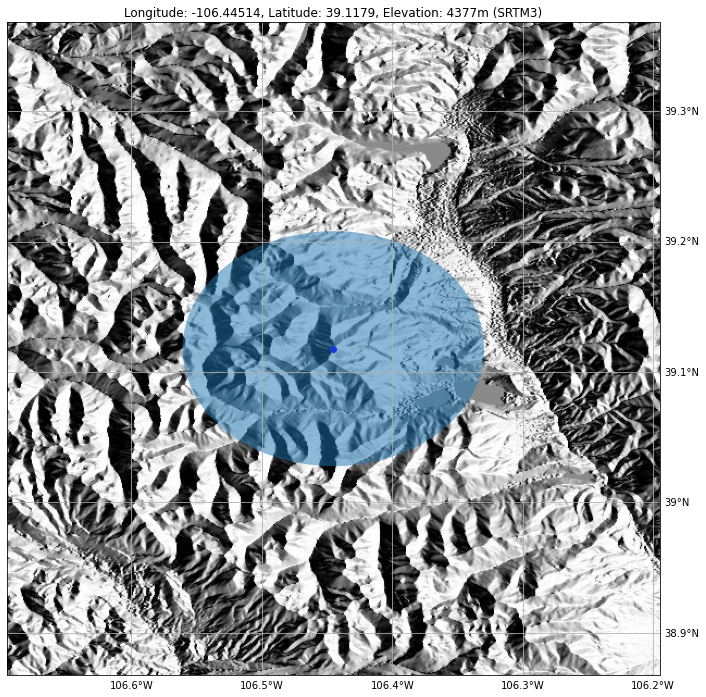

In [43]:
import cartopy.crs as ccrs
from cartopy.io import srtm
import matplotlib.pyplot as plt
import numpy as np


from cartopy import geodesic
import shapely

from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io.srtm import SRTM3Source, SRTM1Source

def getsrtmelevation(source, lon, lat):
    if source == 'SRTM3':
        data = srtm.SRTM3Source().single_tile(int(np.floor(lon)),int(np.floor(lat)))

        # Determine SRTM array indices for lat and lon. Use 1201 for SRTM3 and 3601 for SRTM1
        latindex = int(abs(lat - np.floor(lat)) * (1201 - 1))
        lonindex = int(abs(lon - np.floor(lon)) * (1201 - 1))

        elevation = data[0][latindex, lonindex]
    else:
        data = srtm.SRTM1Source().single_tile(int(np.floor(lon)),int(np.floor(lat)))

        # Determine SRTM array indices for lat and lon. Use 1201 for SRTM3 and 3601 for SRTM1
        latindex = int(abs(lat - np.floor(lat)) * (3601 - 1))
        lonindex = int(abs(lon - np.floor(lon)) * (3601 - 1))

        elevation = data[0][latindex, lonindex]
        
    ## Enable code below to troubleshoot tile array indexing
    #print(data[0])
    #print("latindex: ", latindex, "lonindex: ", lonindex)
    #print("lat: ", lat, "lon: ", lon, "elevation: ", data[0][latindex, lonindex])
    #print(data[0][-1200, -2])
    #print("max tile elevation:", data[0].max())
   
    return elevation


def shade(located_elevations):
    
    ## Given an array of elevations in a LocatedImage, add a relief (shadows) to
    ## give a realistic 3d appearance.
    
    new_img = srtm.add_shading(located_elevations.image,
                               azimuth=90, altitude=5)
    return LocatedImage(new_img, located_elevations.extent)

def viewsheds(lon, lat, rad_km, n_sample):
    ## Add circle of visibility at lon, lat or radius rad_km
    # 145 km is ~90 miles which is avg visibility in western US
    # n_samples represents number of points to plot around circle, 3-triangle, 4-square, etc..

    #ax.add_geometries takes an array of geometries. Define that here with geoms
    geoms = []

    circle = geodesic.Geodesic().circle(lon, lat, rad_km*1e3, n_samples) #define geodesic circle
    circle_geom = shapely.geometry.asPolygon(circle) #convert to shapely geometry
    
    geoms.append(circle_geom) #adds geometry to geoms
    # use the following command to plot in main map after calling function
    # mapplot.add_geometries(geoms, ccrs.PlateCarree())
    
    return geoms

    
def plot(Source, name, lon, lat, elev, londim, latdim):
    plt.figure(figsize=(12,12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.scatter(lon, lat, color='blue', transform=ccrs.PlateCarree())
    
    rad_km = 10
    circles = viewsheds(lon, lat, rad_km, 80)
    ax.add_geometries(circles, ccrs.PlateCarree(), alpha=0.50)
    
    # Define a raster source which uses the SRTM data and applies the
    # shade function when the data is retrieved.
    shaded_srtm = PostprocessedRasterSource(Source(), shade)

    # Add the shaded SRTM source to our map with a grayscale colormap.
    ax.add_raster(shaded_srtm, cmap='Greys')
    
    # Extents Option 1: 
    # Centers point of interest in plot with plot dimensions londim and latdim
    ax.set_extent([lon-0.5*londim, lon+0.5*londim, lat-0.5*latdim, lat+0.5*latdim])  
   
    # Extents Option 2:
    # Plots SRTM tile containing lat,lon location
    # ax.set_extent([int(lon), int(lon) + np.sign(lon)*1, int(lat), int(lat) + np.sign(lat)*1])
    
    plt.title("Longitude: " + str(lon) + ", Latitude: " + str(lat) + ", Elevation: " + str(elev) + "m (" + name + ")")

    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    return ax


def main():
    
    # REFERENCE VALUES
    # [name] (longitude, latitude, elevation)
    # Mt. Elbert (-106.44514, 39.11790, 4401m)
    # Mt. Kilamanjaro (37.35454, -3.07753, 5895m)
    # Mt. Everest (27.99021, 86.92458, N/A)
    # Stone Mountain (-84.14598, 33.80609, 500m)
    # Big Mountain (-114.34135, 48.50270, )
    # Atlanta (-84.37370, 33.78537)
    
    source = 'SRTM3'
    lon = -106.44514
    lat = 39.11790
    elev = getsrtmelevation(source, lon, lat)
    
    ## Plot map
    londim = 0.5 # in degrees
    latdim = 0.5 # in degrees
    if source == 'SRTM3':
        mapplot = plot(SRTM3Source, 'SRTM3', lon, lat, elev, londim, latdim)
    else:
        mapplot = plot(SRTM1Source, 'SRTM1', lon, lat, elev, londim, latdim)  
    
    plt.show()
    
#     ## Add circle of visibility at lon, lat or radius rad_km
#     rad_km = 10 # 145 km is ~90 miles which is avg visibility in western US
#     n_samples = 80 #represents number of points to plot around circle, 3-triangle, 4-square, etc..

#     #ax.add_geometries takes an array of geometries. Define that here with geoms
#     geoms = []

#     circle = geodesic.Geodesic().circle(lon, lat, rad_km*1e3, n_samples) #define geodesic circle
#     circle_geom = shapely.geometry.asPolygon(circle) #convert to shapely geometry
#     geoms.append(circle_geom) #adds geometry to geoms

#     mapplot.add_geometries(geoms, ccrs.PlateCarree())
    
#     plt.show()
     
    

    
if __name__ == '__main__':
    main()

### Draw Circle at Point

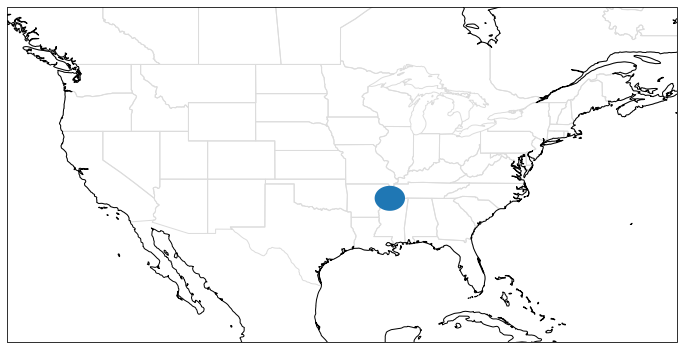

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import geodesic
import shapely

#plot base map
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-130, -60, 20, 55], ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor='gainsboro')
ax.coastlines()

#enter coordinates and radius in km
lon = -90
lat = 35
rad_km = 145 # 145 km is ~90 miles which is avg visibility in western US
n_samples = 80 #represents number of points to plot around circle, 3-triangle, 4-square, etc..

#ax.add_geometries takes an array of geometries. Define that here with geoms
geoms = []

circle = geodesic.Geodesic().circle(lon, lat, rad_km*1e3, n_samples) #define geodesic circle
circle_geom = shapely.geometry.asPolygon(circle) #convert to shapely geometry
geoms.append(circle_geom) #adds geometry to geoms

ax.add_geometries(geoms, ccrs.PlateCarree())
